## Transpilation
Recently, Qiskit introduced `EquivalenceLibrary` and `BasisTranslator` classes in an effort to enable circuit translation across a variety of basis gates. We will use these tools to tranform a circuit to $ R_x $, $ R_z $ and $ CZ $ basis.

We create a `BasisLibrary` (instance of `EquivalenceLibrary`) where we add equivalent definitions for many standard gates using only $ R_x $, $ R_z $ and $ CZ $ gates.

More specifically, the following identities were used:

- $ H = e^{i \frac{\pi}{2}} \cdot R_z\big(\frac{\pi}{2}\big) R_x\big(\frac{\pi}{2}\big) R_z\big(\frac{\pi}{2}\big) $


- $ Z = e^{i \frac{\pi}{2}} \cdot R_z(\pi) $


- $ X = e^{i \frac{\pi}{2}} \cdot R_x(\pi) $


- $ Y = -i \cdot Z X = e^{i \frac{\pi}{2}} \cdot R_z(\pi) R_x(\pi)$


- $ R_y(\phi) = R_z\big(\frac{\pi}{2}\big) R_x(\phi)  R_z\big(-\frac{\pi}{2}\big)$



- 

$ \begin{align*} 
CNOT & = (\mathbb{1} \otimes H) \cdot CZ \cdot (\mathbb{1} \otimes H) \\ 
&= (\mathbb{1} \otimes H) \cdot CZ \cdot (\mathbb{1} \otimes H^\dagger) \\
&=  \Big(\mathbb{1} \otimes e^{i \frac{\pi}{2}} \cdot R_z\big(\frac{\pi}{2}\big) R_x\big(\frac{\pi}{2}\big) R_z\big(\frac{\pi}{2}\big)\Big) \cdot CZ \cdot \Big(\mathbb{1} \otimes e^{-i \frac{\pi}{2}} \cdot R_z\big(-\frac{\pi}{2}\big) R_x\big(-\frac{\pi}{2}\big) R_z\big(-\frac{\pi}{2}\big)\Big) \\
&=  \Big(\mathbb{1} \otimes R_z\big(\frac{\pi}{2}\big) R_x\big(\frac{\pi}{2}\big) \Big) \cdot CZ \cdot \Big(\mathbb{1} \otimes R_x\big(-\frac{\pi}{2}\big) R_z\big(-\frac{\pi}{2}\big)\Big)
\end{align*} $


Afterwards, a pass through `BasisTranslator` will transform the input circuit into an equivalent (up to a global phase) circuit expressed in the desired basis.

In [1]:
from qiskit import QuantumCircuit
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import BasisTranslator

from library import BasisLibrary

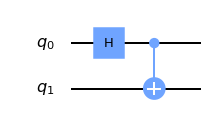

In [2]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

qc.draw('mpl')

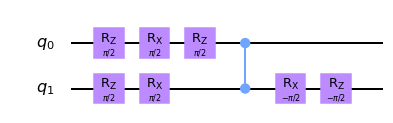

In [3]:
pass_ = BasisTranslator(BasisLibrary,
                        ['rx', 'rz', 'cz'])

pm = PassManager(pass_)
circ = pm.run(qc)

circ.draw('mpl')

## A need for optimization
We further explore the transformation with a random circuit as input. We immediately observe that, after transpilation, the number of gates in the circuit increases a lot. We can calculate the overhead as

$$ |G'| = |G| + |Y| +  2 \cdot |R_y| + 2 \cdot |H| + 4 \cdot |CNOT| $$

where $ |H|, |Y|, |R_y|, |CNOT| $ are the number of $ H, Y, R_y, CNOT $ gates in the original circuit and $ |G|, |G'| $ the total count of gates in the original and transpiled circuit accordingly.


In order to reduce the number of gates, we can apply the following identities:

-  $ \prod_{i=1}^{n}  R_z\big(\phi_i\big) = R_z\big(\sum_{i=1}^{n} \phi_i\big) $


-  $ \prod_{i=1}^{n}  R_x\big(\phi_i\big) = R_x\big(\sum_{i=1}^{n} \phi_i\big) $


-  $ CZ^2 = \mathbb{1} $

and to enable the previous optimizations the following commutation relations may be useful:

- $ X R_z\big(\phi\big) = R_z\big(-\phi \big) X \implies R_x\big(\pm \pi \big) R_z\big(\phi \big) = R_z\big(-\phi \big) R_x\big(\pm \pi \big) $


- $ Z R_x\big(\phi\big) = R_x\big(-\phi \big) Z \implies R_z\big(\pm \pi \big) R_x\big(\phi \big) = R_x\big(-\phi \big) R_z\big(\pm \pi \big) $


- $ \Big(\mathbb{1} \otimes R_z\big(\phi \big)\Big) CZ = CZ \Big(\mathbb{1} \otimes R_z\big(\phi\big)\Big) $

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit

from transpiler import RxzCzTranspiler
from utils.random import random_circuit

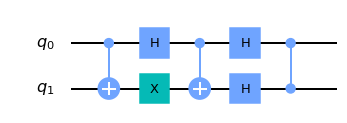

In [5]:
qc = random_circuit(num_qubits=2, depth=5, 
                    seed=20)
qc.draw('mpl')

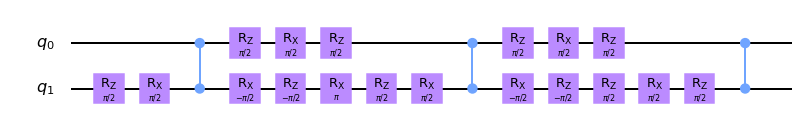

In [7]:
circ = RxzCzTranspiler().run(qc)
circ.draw('mpl')

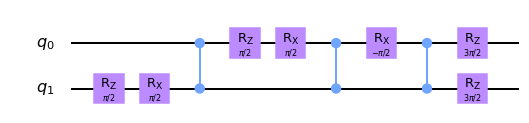

In [8]:
circ_opt = RxzCzTranspiler(optimize=True).run(qc)
circ_opt.draw('mpl')

In [9]:
print('Original circuit:    ', qc.size())
print('After transpilation: ', circ.size())
print('After optimization:  ', circ_opt.size())

Original circuit:     7
After transpilation:  21
After optimization:   10


## Benchmark
In order to get a better sense of the final circuit size, we run the transpilation and optimization steps a few times for randomly sampled circuits with different number of qubits and depths.

The circuit sampling procedure is the following:

-  We apply a 2-qubit gate ($ CNOT, CZ $) on  two randomly selected qubits with probability $ \frac{1}{2} $. Otherwise, we apply a single-qubit gate ($ H, Z, X, Y,  R_z, R_x, R_y $). 

This means that the estimated overhead of the transpiled circuit is  $ \frac{|G'|}{|G|} = 2 +  \frac{3}{14} \approx 2.2 $. (using previous equation)

After running the becnhmarks, we can see a significant reduction in the number of gates thanks to the optimization procedure as the final circuit size approaches the original size ($\approx 1.2 $ times larger) and even reduces it some times, especially in circuits with greater depth.

In [10]:
N_ITER = 20
N_QUBITS = [2, 3, 6]
DEPTHS   = [3, 5, 10, 20]

original   = [[[] for _ in DEPTHS] for _ in N_QUBITS]
transpiled = [[[] for _ in DEPTHS] for _ in N_QUBITS]
optimized  = [[[] for _ in DEPTHS] for _ in N_QUBITS]

for q, num_qubits in enumerate(N_QUBITS):
    for d, depth in enumerate(DEPTHS):
        for _ in range(N_ITER):
        
            qc = random_circuit(num_qubits, depth)
            original[q][d] += [qc.size()]

            circ = RxzCzTranspiler().run(qc)
            transpiled[q][d] += [circ.size()]

            circ_opt = RxzCzTranspiler(optimize=True).run(qc)
            optimized[q][d] += [circ_opt.size()]  

### Visualization
We plot the total count of gates and the ratio of gates in the transpiled  (optimized) circuit to gates in the original circuit vs increasing depth.

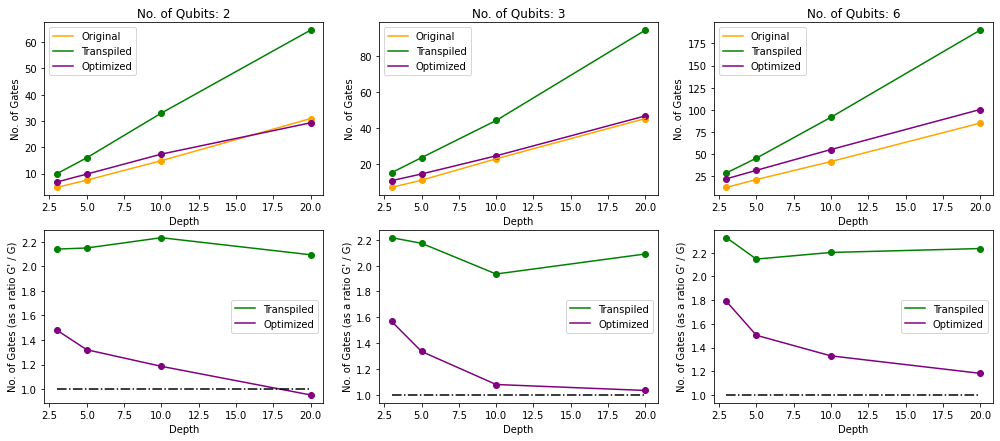

In [11]:
plt.figure(figsize=(17, 7));
cols = ('orange', 'green', 'purple')

for q, num_qubits in enumerate(N_QUBITS):

    # plot circuits sizes.
    plt.subplot(200 + 10 * len(N_QUBITS) + q + 1)
    
    # original
    plt.scatter(DEPTHS, np.mean(original[q], axis=1), 
                c=cols[0])
    plt.plot(DEPTHS, np.mean(original[q], axis=1), 
             c=cols[0], label='Original'.format(num_qubits))
    
    # transpiled
    plt.scatter(DEPTHS, np.mean(transpiled[q], axis=1) , 
                c=cols[1])
    plt.plot(DEPTHS, np.mean(transpiled[q], axis=1), 
             c=cols[1], label='Transpiled'.format(num_qubits))
    
    
    # optimized
    plt.scatter(DEPTHS, np.mean(optimized[q], axis=1), 
                c=cols[2])
    plt.plot(DEPTHS, np.mean(optimized[q], axis=1) , 
             c=cols[2], label='Optimized'.format(num_qubits))
    
    
    plt.legend()
    plt.xlabel('Depth')
    plt.ylabel('No. of Gates');
    plt.title('No. of Qubits: {}'.format(num_qubits))
    
    
    
    
    # plot as ratio of original circuit size.
    plt.subplot(200 + 10 * len(N_QUBITS) + len(N_QUBITS) + q + 1)
    
    # transpiled
    transpiled_ratio = np.array(transpiled[q]) / np.array(original[q])
    plt.scatter(DEPTHS, np.mean(transpiled_ratio, axis=1), 
                c=cols[1])
    plt.plot(DEPTHS, np.mean(transpiled_ratio, axis=1), 
             c=cols[1], label='Transpiled'.format(num_qubits))
    
    
    # optimized
    optimized_ratio = np.array(optimized[q]) / np.array(original[q])
    plt.scatter(DEPTHS, np.mean(optimized_ratio, axis=1), 
                c=cols[2])
    plt.plot(DEPTHS, np.mean(optimized_ratio, axis=1),
             c=cols[2], label='Optimized'.format(num_qubits))

    
    plt.plot(DEPTHS, np.ones(len(DEPTHS)), c='black', linestyle='-.')
    
    
    plt.legend()
    plt.xlabel('Depth')
    plt.ylabel('No. of Gates (as a ratio G\' / G)');